<h1>Sieci neuronowe - ćwiczenie 3</h1>

In [1]:
!pip install ucimlrepo


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

<h3>Przygotowanie danych na podstawie poprzedniego ćwiczenia</h3>

In [3]:
# original code from https://archive.ics.uci.edu/dataset/45/heart+disease
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
heart_data = heart_disease.data.original

In [4]:
df: pd.DataFrame = heart_data

# repearing of the inbalnace in classification and removing null values
df["num"] = df["num"].replace([2, 3, 4], 1) #change classes to binary classification
print(df["num"].value_counts())

#get null values of ca and remove them
null_idx = df[df["ca"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

#get null values of thel and remove them
null_idx = df[df["thal"].isnull()].index 
print(null_idx)
df = df.drop(null_idx)
df = df.reset_index(drop=True) 
print(df["num"].value_counts())

# balance classes to same amount 138
random_idx = df.query("num == 0").sample(df["num"].value_counts()[0] - df["num"].value_counts()[1]).index 
df = df.drop(random_idx)
df = df.reset_index(drop=True)
print(df["num"].value_counts())

df_without_num = df.loc[:, df.columns != "num"]
std_features = (df_without_num - df_without_num.mean() )/ df_without_num.std() #(value-mean)/variance

result = std_features
result["heart_disease"] = df["num"]

# data not standarized 4. Danych znormalizowanych i nieznormalizowanych
n_std_result = df_without_num
n_std_result["heart_disease"] = df["num"]

result

num
0    164
1    139
Name: count, dtype: int64
Index([166, 192, 287, 302], dtype='int64')
num
0    161
1    138
Name: count, dtype: int64
Index([87, 264], dtype='int64')
num
0    160
1    137
Name: count, dtype: int64
num
0    137
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart_disease
0,0.931950,0.675113,-2.236645,0.740293,-0.277515,2.379535,1.012907,0.044566,-0.715498,1.017122,2.215324,-0.758238,0.613001,0
1,1.369950,0.675113,0.863730,1.569114,0.808758,-0.418716,1.012907,-1.748654,1.392528,0.348396,0.617959,2.373779,-0.927937,1
2,1.369950,0.675113,0.863730,-0.641076,-0.359498,-0.418716,1.012907,-0.852044,1.392528,1.267894,0.617959,1.329773,1.126647,1
3,-1.915052,0.675113,-0.169729,-0.088529,0.070912,-0.418716,-0.998227,1.624307,-0.715498,2.020211,2.215324,-0.758238,-0.927937,0
4,-1.477052,-1.475828,-1.203187,-0.088529,-0.871891,-0.418716,1.012907,0.983871,-0.715498,0.264806,-0.979406,-0.758238,-0.927937,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.274949,-1.475828,0.863730,0.464019,-0.113549,-0.418716,-0.998227,-1.108218,1.392528,-0.738283,0.617959,-0.758238,1.126647,1
270,-1.039052,0.675113,-2.236645,-1.193624,0.357852,-0.418716,-0.998227,-0.723957,-0.715498,0.097624,0.617959,-0.758238,1.126647,1
271,1.479450,0.675113,0.863730,0.685038,-1.097344,2.379535,-0.998227,-0.339696,-0.715498,1.936620,0.617959,1.329773,1.126647,1
272,0.274949,0.675113,0.863730,-0.088529,-2.368080,-0.418716,-0.998227,-1.449784,1.392528,0.097624,0.617959,0.285768,1.126647,1


In [5]:
def train_test_split(features, targets, percentage):
    choices = np.random.choice(range(features.shape[0]), size=(int(features.shape[0] * percentage/100),), replace=False) 
    split = np.zeros(features.shape[0], dtype=bool)
    split[choices] = True

    return features[split], targets[split], features[~split], targets[~split]

In [6]:
features = result.loc[:, result.columns != "heart_disease"].to_numpy()
targets = result["heart_disease"].to_numpy()

x_train, y_train, x_test, y_test = train_test_split(features, targets, 70)

<h1>Przygotowanie modelu</h1>

In [7]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))


def sigmoid_der(n):
    return sigmoid(n) * (1 - sigmoid(n))

In [8]:
class Neuron:
    _weights: np.ndarray
    _bias: float
    _cache_x: np.ndarray
    _err: np.ndarray 

    def init_weights(self, size: int, std_dev: float):
        self._weights = np.random.normal(scale=std_dev, size=size) # initialize weights 
        self._bias = np.random.normal(scale=std_dev) #initialize bias 

    def forward(self, x: np.ndarray) -> np.ndarray:
       self._cache_x = x
       
       return sigmoid(np.dot(x, self._weights) + self._bias)
    
    def backward(self, error: np.ndarray):
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err
    
    def backward_weights(self, error: np.ndarray, next_weights: np.ndarray):
       error = error.T @ next_weights
       self._err = error * sigmoid_der(np.dot(self._cache_x, self._weights) + self._bias) 
       return self._err

    def update_weights(self, learning_rate: float):
      self._weights = self._weights - learning_rate * np.dot(self._cache_x.T, self._err)
      self._bias = self._bias - learning_rate * np.sum(self._err)

    def get_weights(self):
       return self._weights  

    def get_bias(self):
       return self._bias  
    
class MultilayerNetwork:
    def __cross_entropy_loss(self, y, y_pred):
        return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis=1)

    def __cross_entropy_loss_der(self, y, y_pred):
        return -np.sum(y / y_pred - (1 - y) / (1 - y_pred), axis=1)
    
    def __init__(self, hidden_layers_sizes):
        self._layers: list[list[Neuron]] = []
   
        for index, layer_size in enumerate(hidden_layers_sizes):
            self._layers.append([])
            for _ in range(layer_size):
                self._layers[index].append(Neuron()) 

        # output layer
        self._layers.append([])
        self._layers[-1].append(Neuron())        

    def optimize(self, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, batch_size: int, learning_rate: float, 
                        max_iter: int, std_dev: float, verb = False):
        
        losses = [] 
        weights = []
        biases = []
        losses_test = []

        accuracy = []
        f_score = []
        recalls = []

        curr_size_layer = x_train.shape[1]
      
        for layer in self._layers:
            for neuron in layer:
                neuron.init_weights(curr_size_layer, std_dev) 
            curr_size_layer = len(layer)

        #fix shape of y data to match further calculations
        if len(y_test.shape) == 1:
            y_test = y_test[np.newaxis].T 

        if len(y_train.shape) == 1:
            y_train = y_train[np.newaxis].T

        if batch_size > x_train.shape[0]:
            batch_size = x_train.shape[0]

        for index in range(max_iter): #learn for max_iter      
            shuffle = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[shuffle]
            y_train_shuffled = y_train[shuffle]

            for batch_start_index in range(0, x_train.shape[0], batch_size):
                x_train_batch = x_train_shuffled[batch_start_index:batch_start_index+batch_size] 
                y_train_batch = y_train_shuffled[batch_start_index:batch_start_index+batch_size] 

                pred = self.forward(x_train_batch)
                self.backward(y_train_batch, pred)

                for layer in self._layers:
                    for neuron in layer:
                        neuron.update_weights(learning_rate)
            
            new_train_loss = np.mean(self.__cross_entropy_loss(y_train_batch, pred))
         
            #calculate loss of test data
            test_pred = self.predict(x_test)
            new_test_loss = np.mean(self.__cross_entropy_loss(y_test, test_pred))

            #append to helper lists
            losses.append(new_train_loss)
            weights.append(self.__get_weights())
            biases.append(self.__get_biases())
            losses_test.append(new_test_loss)

            test_pred[test_pred >= 0.5] = 1
            test_pred[test_pred < 0.5] = 0

            #calculate scores for each iteration
            accuracy.append(metrics.accuracy_score(y_test, test_pred))
            f_score.append(metrics.f1_score(y_test, test_pred))
            recalls.append(metrics.recall_score(y_test, test_pred))

        if verb:
         #plot results
            plt.plot(np.arange(len(losses)), losses, label="Train Loss")
            plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
            plt.legend()
            plt.show()

        #print final weight, bias, loss and scores
            print("Weights: ", self.__get_weights())
            print("Bias: ", self.__get_biases())
         
        print("Train loss: ", losses[-1])
        print("Test loss: ", losses_test[-1])

        print("Scores")
        print("Accuracy: ", accuracy[-1])
        print("F_score: ", f_score[-1])
        print("Recall: ", recalls[-1])
        return losses, weights, biases, losses_test, accuracy, f_score, recalls  

    def forward(self, x: np.ndarray) -> float:
        for layer in self._layers:
            x = np.array([neuron.forward(x) for neuron in layer]).T
        return x

    def backward(self, y_train: np.ndarray, y_pred: np.ndarray) -> list[list[np.ndarray[float]]]:
        err = np.array([out_neuron.backward(self.__cross_entropy_loss_der(y_train, y_pred)) for out_neuron in self._layers[-1]])
        next_weights = np.array([out_neuron.get_weights() for out_neuron in self._layers[-1]]).T

        for layer in reversed(self._layers[:-1]):
            err = np.array([neuron.backward_weights(err, next_weights[neuron_index]) for neuron_index, neuron in enumerate(layer)])
            next_weights = np.array([neuron.get_weights() for neuron in layer]).T
         

    def predict(self, x_test: np.ndarray) -> np.ndarray:
        return self.forward(x_test) 
    
    def __get_weights(self) -> []:
        weights = []
        for layer in self._layers:
            weights.append([neuron.get_weights() for neuron in layer])     
        return weights
    
    def __get_biases(self) -> []:
        biases = []
        for layer in self._layers:
            biases.append([neuron.get_bias() for neuron in layer])     
        return biases 
   

In [9]:
#1. Różnej wymiarowości warstwy ukrytej
hidden1 = (4, 3)
hidden2 = (20, 10)
hidden3 = (100, 50)

#2. Różnej wartości współczynnika uczenia
learning1 = 0.001
learning2 = 0.01

#3. Różnych odchyleń standardowych przy inicjalizacji wag
std_dev1 = 0.8
std_dev2 = 0.3

#5. Różnej liczby warstw
hidden4 = (20,)
hidden5 = (20, 20)
hidden6 = (20, 20, 20)

max_iter = 500

<p>1. Różnej wymiarowości warstwy ukrytej</p>

In [10]:
ex1 = MultilayerNetwork(hidden1)
ex2 = MultilayerNetwork(hidden2)
ex3 = MultilayerNetwork(hidden3)

r1 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r2 = ex2.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)
r3 = ex3.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.4)

Train loss:  0.6810718789520185
Test loss:  0.40606551561623755
Scores
Accuracy:  0.8313253012048193
F_score:  0.8157894736842106
Recall:  0.775
Train loss:  0.30488813935439535
Test loss:  0.38435330268352463
Scores
Accuracy:  0.8192771084337349
F_score:  0.7999999999999999
Recall:  0.75
Train loss:  0.17541410356709258
Test loss:  0.3992720289985059
Scores
Accuracy:  0.8072289156626506
F_score:  0.7894736842105262
Recall:  0.75


<p>2. Różnej wartości współczynnika uczenia</p>

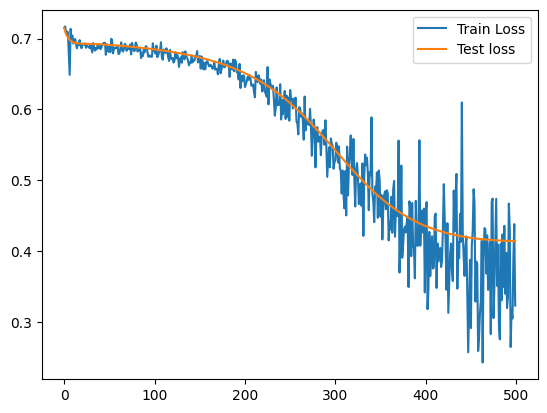

Weights:  [[array([-0.10754229, -0.40701637, -0.73546582, -0.2553596 , -0.01009276,
        0.54835483,  0.58290585,  0.29961575, -0.82559665, -0.39417443,
       -0.17892324, -0.67941343, -0.82533628]), array([ 0.04004264,  0.53821858,  0.92143507,  0.15310306, -0.33810827,
       -0.02049471,  0.55792983, -0.87118719,  0.58236637,  0.51578523,
       -0.13736222,  0.74818599,  1.16141593]), array([-0.35912373, -0.72587989, -0.48298541, -0.13036916,  0.88509268,
        0.20987934,  0.32675514, -0.6496857 , -0.25261839, -0.82223323,
       -0.00974425, -0.4077755 , -1.2005264 ]), array([ 0.29196331,  0.05358777, -0.15928188,  0.27916428,  0.43790075,
       -0.23737559,  0.40243677, -0.33781862,  0.35431128,  0.2338524 ,
        0.32600468,  0.72516111,  0.51768185])], [array([-1.05732046,  1.89373148, -0.74905614,  0.93451612]), array([ 1.62659517, -1.55704435,  0.59805289, -0.81268597]), array([ 0.40044449,  0.48327743, -0.11163046,  0.78990395])], [array([ 2.6664766 , -2.57094767, 

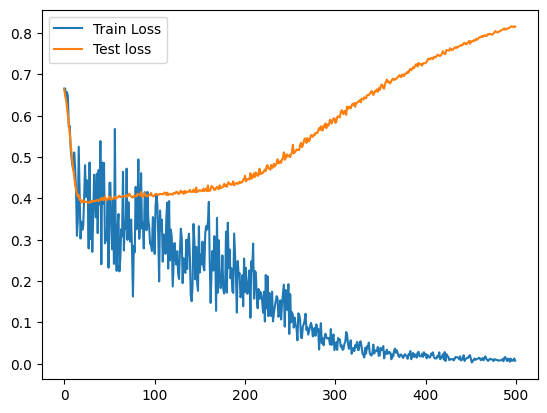

Weights:  [[array([-0.07788037,  1.37666638, -0.22560805, -1.56190342, -0.24349842,
       -1.09504859,  0.05992095,  0.9267534 ,  0.08230157,  0.33749589,
       -0.28963819, -0.23967179, -0.54200816]), array([ 0.16130328, -0.2525866 , -0.37826395, -0.01938181, -0.20534996,
        0.07581534, -0.26588108, -0.35742062, -0.19485428,  0.0762983 ,
        0.08469632,  0.14205076, -0.11151284]), array([ 0.38993343,  0.25208087,  0.43523617, -0.9776133 ,  0.99878074,
       -0.26361487, -0.2477967 , -0.32480672,  0.48989661, -1.00214086,
        0.99838879,  0.03650651,  0.72532463]), array([ 0.81657896,  1.31333435,  1.87717771,  1.38578539, -0.28172557,
       -0.99150736,  0.37099986, -0.43867408,  0.08299579, -0.60777252,
       -0.80199321, -0.67622839,  0.69183582]), array([ 0.00304085, -0.25863823, -0.73344577, -0.50213264, -0.66365291,
       -0.45594521, -0.35098202,  0.14742132, -0.1277164 , -0.32814921,
        0.01049081,  0.64697417, -0.15135465]), array([ 0.37191796,  0.00529

In [11]:
ex4 = MultilayerNetwork(hidden2)
ex5 = MultilayerNetwork(hidden2)

r4 = ex1.optimize(x_train, y_train, x_test, y_test, 50, learning1, max_iter, 0.4, verb=True)
r5 = ex2.optimize(x_train, y_train, x_test, y_test, 50, learning2, max_iter, 0.4,  verb=True)

<p>3. Różnych odchyleń standardowych przy inicjalizacji wag</p>

In [12]:
ex6 = MultilayerNetwork(hidden2)
ex7 = MultilayerNetwork(hidden2)

r6 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, std_dev1)
r7 = ex2.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, std_dev2)

Train loss:  0.3443267693221349
Test loss:  0.43433511917435136
Scores
Accuracy:  0.8072289156626506
F_score:  0.7894736842105262
Recall:  0.75
Train loss:  0.5344846818713478
Test loss:  0.4007467943971411
Scores
Accuracy:  0.8192771084337349
F_score:  0.7999999999999999
Recall:  0.75


<p>4. Danych znormalizowanych i nieznormalizowanych</p>

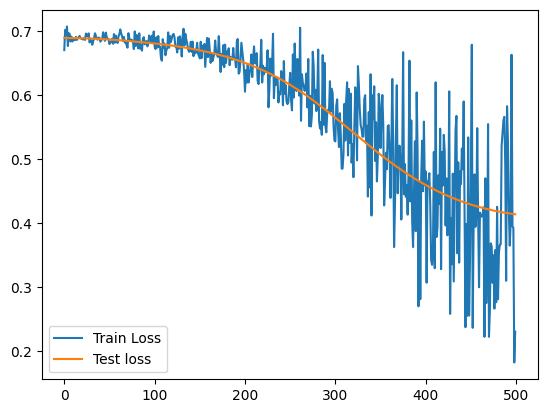

Weights:  [[array([-0.30863767, -1.03009973,  0.46302025, -0.71415844,  0.51618902,
       -0.57894487, -0.77514741, -0.61572732,  1.18082844, -1.00030318,
       -0.28958178,  0.08297332, -0.79237997]), array([ 0.16651353,  0.33279573,  0.43465154, -0.29972289, -0.04045995,
       -0.16715454,  0.31571566, -1.07645389,  1.09351671,  0.10692225,
        0.25325028,  0.20376463,  0.64064965]), array([ 0.47269381,  0.13164951,  0.61092054,  0.4260027 ,  0.15449361,
       -0.39486467, -0.10302269,  0.05967885,  0.50990607,  1.06966048,
        0.13010526,  1.18363213,  1.06127967]), array([ 0.45516715, -0.20594896, -0.32797781, -0.49905991, -0.01152186,
        0.11015706,  0.27894068,  0.14968842, -0.79013905, -0.42963171,
       -1.04092814, -0.69451037, -0.66528913])], [array([-0.50913718,  1.03260541,  1.82896014, -1.40811153]), array([ 0.61271932, -1.40715371, -1.22018351,  0.77372107]), array([ 0.6317594 ,  0.64701689, -0.10340492,  0.77869309])], [array([ 2.8175771 , -2.18814515, 

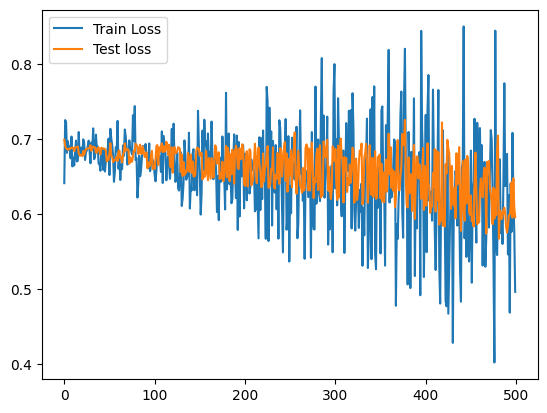

Weights:  [[array([-0.33118436, -0.6271811 , -0.10457847, -0.35485242, -0.83048055,
        0.12826959,  0.18479507,  0.03624718, -0.850261  , -0.57404112,
        1.0919263 , -0.83374411,  0.92271347]), array([-1.24082331,  0.19329191, -0.26177955, -0.30594375,  0.04945191,
       -0.8266413 , -0.08480609,  0.60996763, -0.34603163,  0.13611314,
       -1.26781736,  0.08620907, -0.67890329]), array([ 0.06859072,  0.53088494,  0.35525153,  1.12337806,  0.20049763,
       -0.02976171, -0.26362409, -1.24255203,  0.41491407,  0.0709519 ,
        0.10210382, -0.39099258,  0.42670185]), array([-0.14488   , -0.12135321, -0.42957231, -0.20358049, -0.53983302,
        1.00281832, -0.06479452,  0.41835083, -0.08981426,  0.55336597,
        0.16654588,  0.48277242, -0.29671784]), array([ 0.31667698, -1.1142814 ,  0.73945324, -0.32175261, -0.00740066,
       -0.00323623, -0.3280801 , -0.5655015 , -0.85844847, -0.18376522,
       -0.15174744,  0.11515083,  0.68976658]), array([ 0.45533772,  0.37065

In [13]:
features_n_std = n_std_result.loc[:, result.columns != "heart_disease"].to_numpy()
targets_n_std = n_std_result["heart_disease"].to_numpy()

x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std = train_test_split(features_n_std, targets_n_std, 70)

ex8 = MultilayerNetwork(hidden2)
ex9 = MultilayerNetwork(hidden2)

r8 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5, verb=True)
r9 = ex2.optimize(x_train_n_std, y_train_n_std, x_test_n_std, y_test_n_std, 30, 0.001, max_iter, 0.5, verb=True)

<p>5. Różnej liczby warstw</p>

In [14]:
ex10 = MultilayerNetwork(hidden4)
ex11 = MultilayerNetwork(hidden5)
ex12 = MultilayerNetwork(hidden6)

r10 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)
r11 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)
r12 = ex1.optimize(x_train, y_train, x_test, y_test, 30, 0.001, max_iter, 0.5)

Train loss:  0.47707055035166496
Test loss:  0.42410074958657656
Scores
Accuracy:  0.8313253012048193
F_score:  0.8157894736842106
Recall:  0.775
Train loss:  0.48929140061939674
Test loss:  0.4205120812411943
Scores
Accuracy:  0.8072289156626506
F_score:  0.7894736842105262
Recall:  0.75
Train loss:  0.3475547394933067
Test loss:  0.40589608476013556
Scores
Accuracy:  0.8192771084337349
F_score:  0.7999999999999999
Recall:  0.75
